In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../scripts')

from plot_functions import plot_job_summary_violin, sci_cat_pie_chart, subplot_util_dist, plot_util_dist, plot_power_dist, plot_energy_dist,  plot_tif_dist, plot_sif_dist, subplot_ai_dist, plot_ai_dist, plot_fp_heatmap, plot_ratio_dist
from metric_analysis import find_max_ai, find_mean_ai, check_metrics, clean_and_compare, find_tif_power


In [ ]:
vasp_data = pd.read_parquet('VASP_march_jobs_ai_fixed.parquet')

In [3]:
#vasp_data = vasp_data[vasp_data['max_power'] < 1e13]
print(f"Parsed {len(vasp_data)} job records\n")
print("*******")
print(f"Requested Memory: Min {min(vasp_data['req_mem_mb'])} - Median {(vasp_data['req_mem_mb'].median())} - Max {max(vasp_data['req_mem_mb'])} MB")
print(f"Requested GPU: Min {min(vasp_data['req_gpus'])} - Median {(vasp_data['req_gpus'].median())} - Max {max(vasp_data['req_gpus'])} GPUs")
print(f"Requested Number of Node: Min {min(vasp_data['req_node'])} - Median {(vasp_data['req_node'].median())} - Max {max(vasp_data['req_node'])} nodes")
print(f"Allocated Number of Nodes: Min {min(vasp_data['AllocNodes'])} - Median {(vasp_data['AllocNodes'].median())} - Max {max(vasp_data['AllocNodes'])} nodes")
print(f"Requested CPU: Min {min(vasp_data['req_cpu'])} - Median {(vasp_data['req_cpu'].median())} - Max {max(vasp_data['req_cpu'])} CPUs")
print(f"Requested Time: Min {min(vasp_data['req_time'])} - Median {(vasp_data['req_time'].median())} - Max {max(vasp_data['req_time'])} seconds")

print("*******")
print(f"Average Power Utilization per Job: {min(vasp_data['avg_power'])} - {max(vasp_data['avg_power'])} W")
print(f"Maximum Power Utilization per Job: {min(vasp_data['max_power'])} - {max(vasp_data['max_power'])} W")
print("*******\n")
print(f"Number of unique users: {vasp_data['User'].nunique()}")
print(f"Number of unique users (UID): {vasp_data['UID'].nunique()}")
print(f"Number of unique accounts: {vasp_data['Account'].nunique()}")
print(f"Number of unique categories: {vasp_data['Category'].nunique()}")
print(f"Number of unique job names: {vasp_data['JobName'].nunique()}")

# Check columns
#vasp_data.columns.to_list()

Parsed 32322 job records

*******
Requested Memory: Min 229902 - Median 229902.0 - Max 34485300 MB
Requested GPU: Min 4 - Median 4.0 - Max 600 GPUs
Requested Number of Node: Min 1 - Median 1.0 - Max 150 nodes
Allocated Number of Nodes: Min 1.0 - Median 1.0 - Max 150.0 nodes
Requested CPU: Min 128 - Median 128.0 - Max 19200 CPUs
Requested Time: Min 300.0 - Median 780.0 - Max 172800.0 seconds
*******
Average Power Utilization per Job: 50.97953709198813 - 35184372088959.11 W
Maximum Power Utilization per Job: 52.521 - 140737488355330.0 W
*******

Number of unique users: 128
Number of unique users (UID): 128
Number of unique accounts: 78
Number of unique categories: 15
Number of unique job names: 19949


In [4]:
node_bins = [1, 2, 4, 8, 16, np.inf] 
node_labels = ['1', '[2, 4)' , '[4, 8)', '[8, 16)', '>=16']

vasp_data['node_group'] = pd.cut(vasp_data['req_node'], bins=node_bins, labels=node_labels, right=False)

print(vasp_data['node_group'].value_counts(normalize=True).sort_index() * 100)



node_group
1          86.659241
[2, 4)     10.707877
[4, 8)      2.273993
[8, 16)     0.266073
>=16        0.092816
Name: proportion, dtype: float64


In [5]:
vasp_data['texec_hrs'] = vasp_data['ElapsedSecs']/3600

hrs_bins = [0, 1, 2, 6, 12, 24] 
hrs_labels = ['[0, 1)', '[1, 2)' , '[2, 6)', '[6, 12)', '[12, 24)']

vasp_data['texec_group'] = pd.cut(vasp_data['texec_hrs'], bins=hrs_bins, labels=hrs_labels, right=False)

print(vasp_data['texec_group'].value_counts(normalize=True).sort_index() * 100)



texec_group
[0, 1)      96.042943
[1, 2)       1.039540
[2, 6)       1.649032
[6, 12)      0.618774
[12, 24)     0.649712
Name: proportion, dtype: float64


/global/u2/b/boztop/dcgm_slurm_studies/notebooks/../scripts/plot_functions.py:100: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


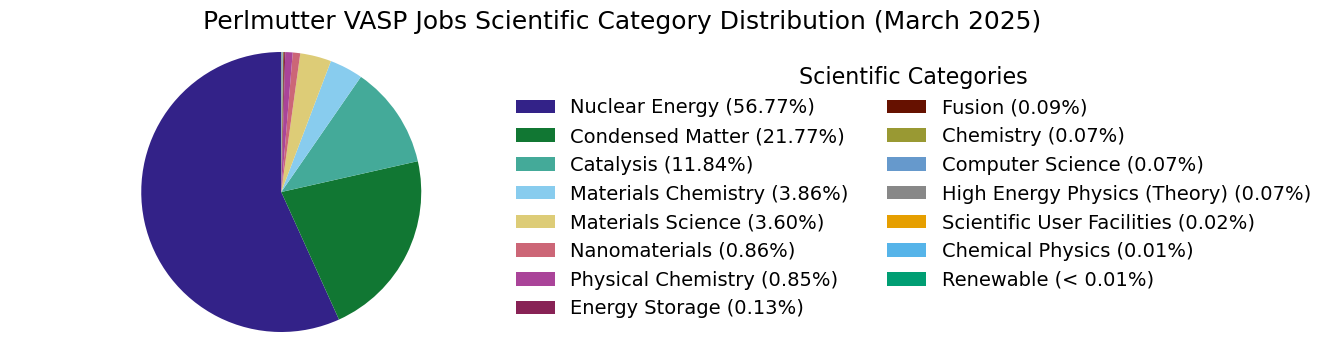

In [6]:
sci_cat_pie_chart(vasp_data)

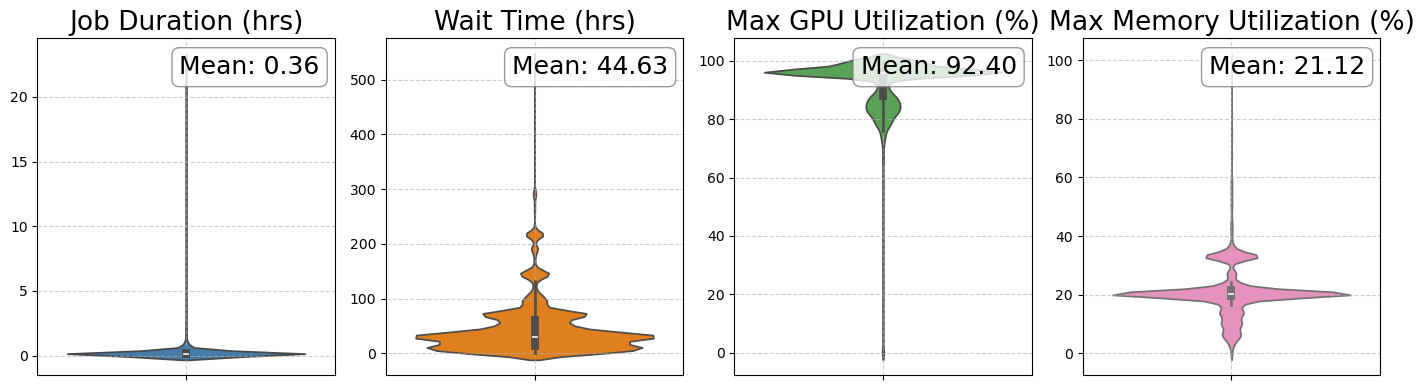

In [7]:
plot_job_summary_violin(vasp_data)

CDF and PDF Plots

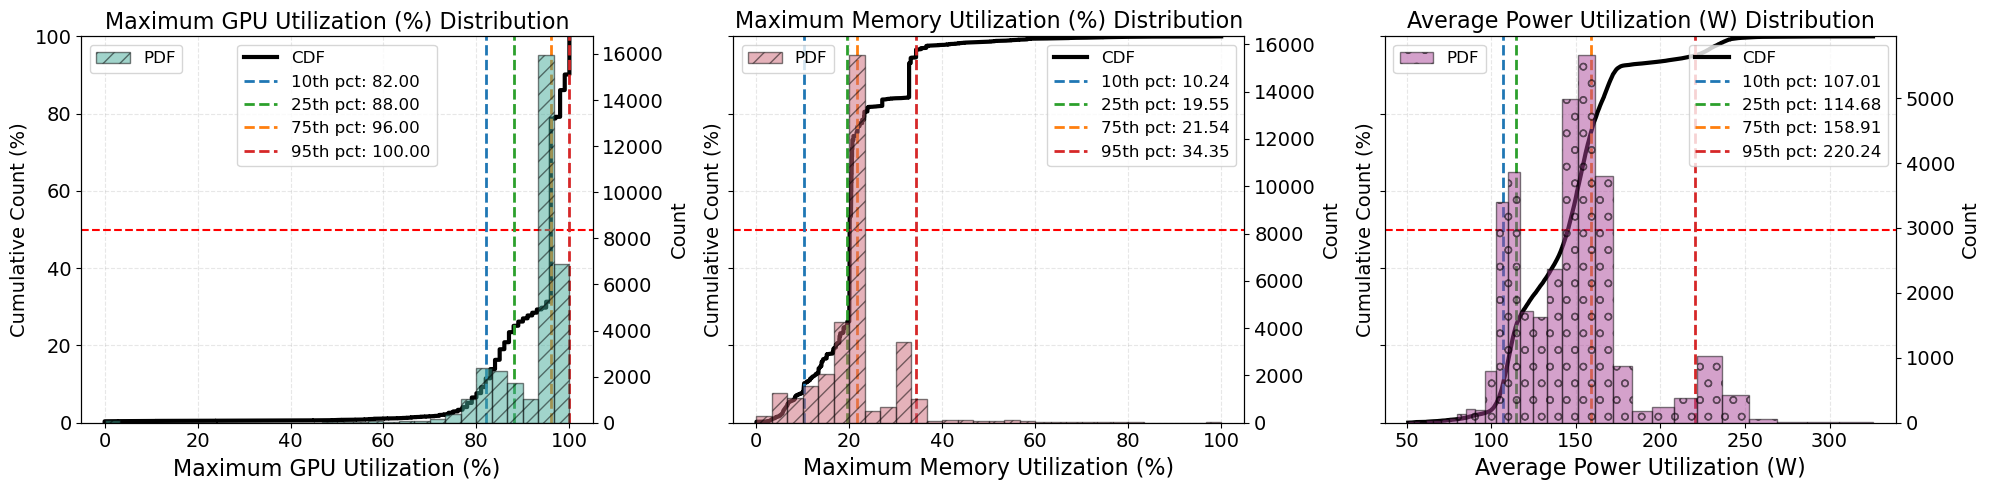

In [8]:
subplot_util_dist(vasp_data,'gpu_utilization_max' , 'mem_util_max', 'avg_power','Perlmutter VASP Jobs Resource Utilization Distributions (March 2025)' , '#44AA99', '#CC6677', '#AA4499' )

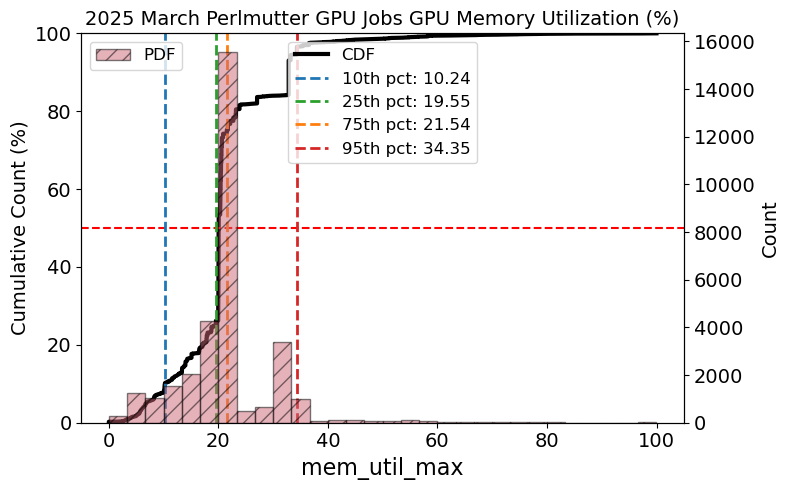

In [9]:
plot_util_dist(vasp_data, 'mem_util_max', '2025 March Perlmutter GPU Jobs GPU Memory Utilization (%)',color='#CC6677')  

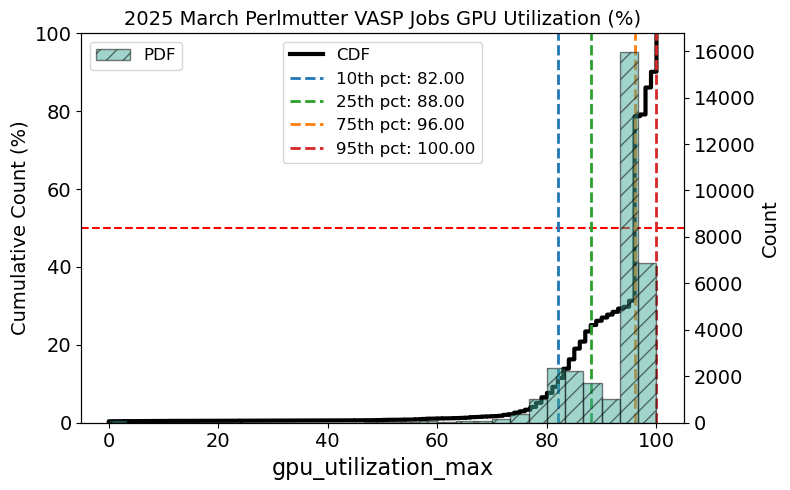

In [10]:
plot_util_dist(vasp_data, 'gpu_utilization_max', '2025 March Perlmutter VASP Jobs GPU Utilization (%)',color='#44AA99')  

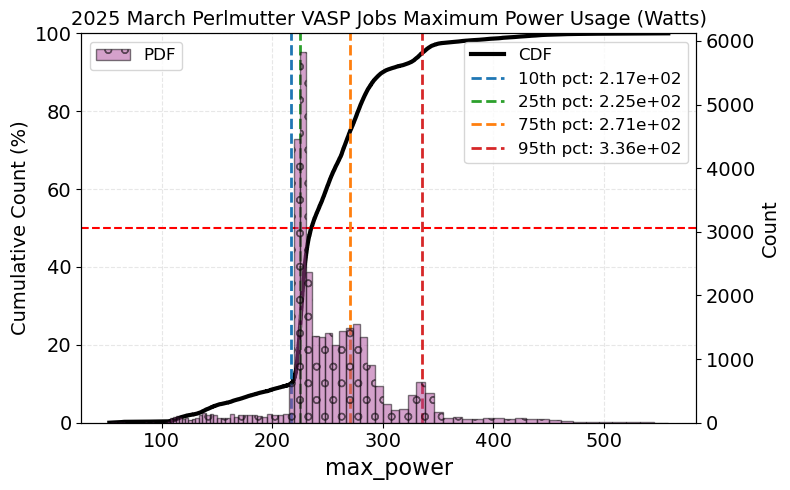

246.84932569816817


In [11]:
power_df = vasp_data[vasp_data['max_power'] < 1e13] # disregarding the tail; total of 59 jobs
plot_power_dist(power_df, 'max_power', '2025 March Perlmutter VASP Jobs Maximum Power Usage (Watts)', color="#AA4499")
print(power_df['max_power'].mean())

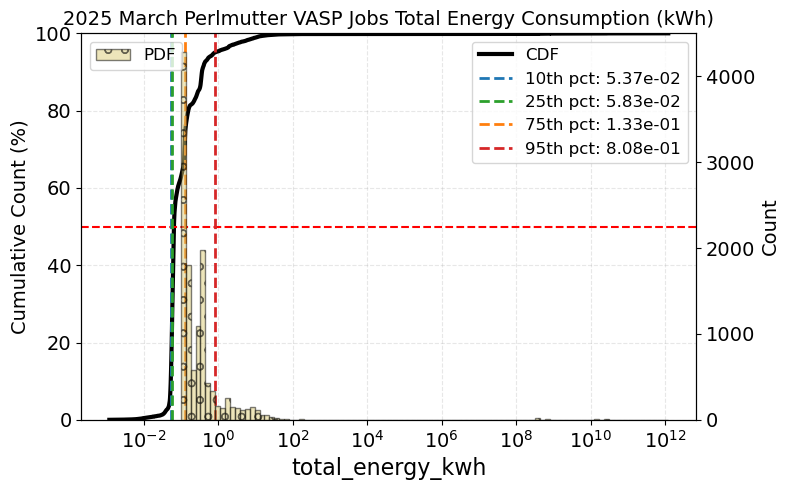

In [12]:
plot_energy_dist(vasp_data, 'total_energy_kwh', '2025 March Perlmutter VASP Jobs Total Energy Consumption (kWh)', color="#DDCC77")

AI Metric Visualization

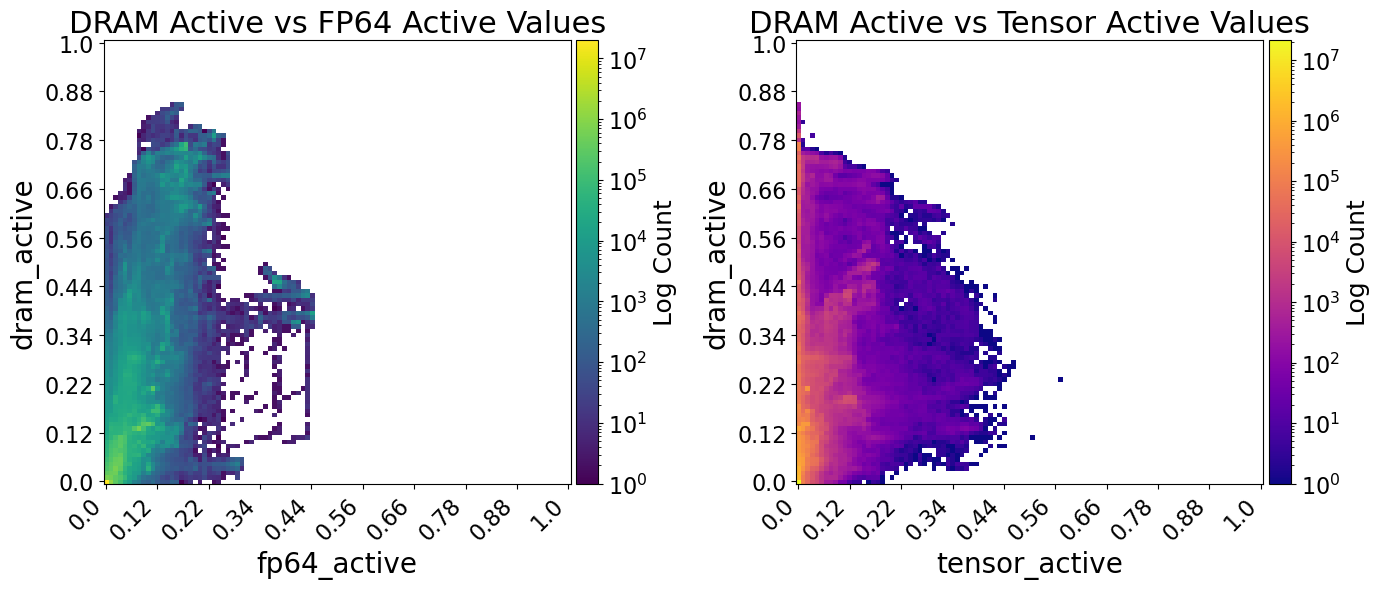

In [13]:
plot_fp_heatmap(vasp_data,'total_fp64','total_tensor')


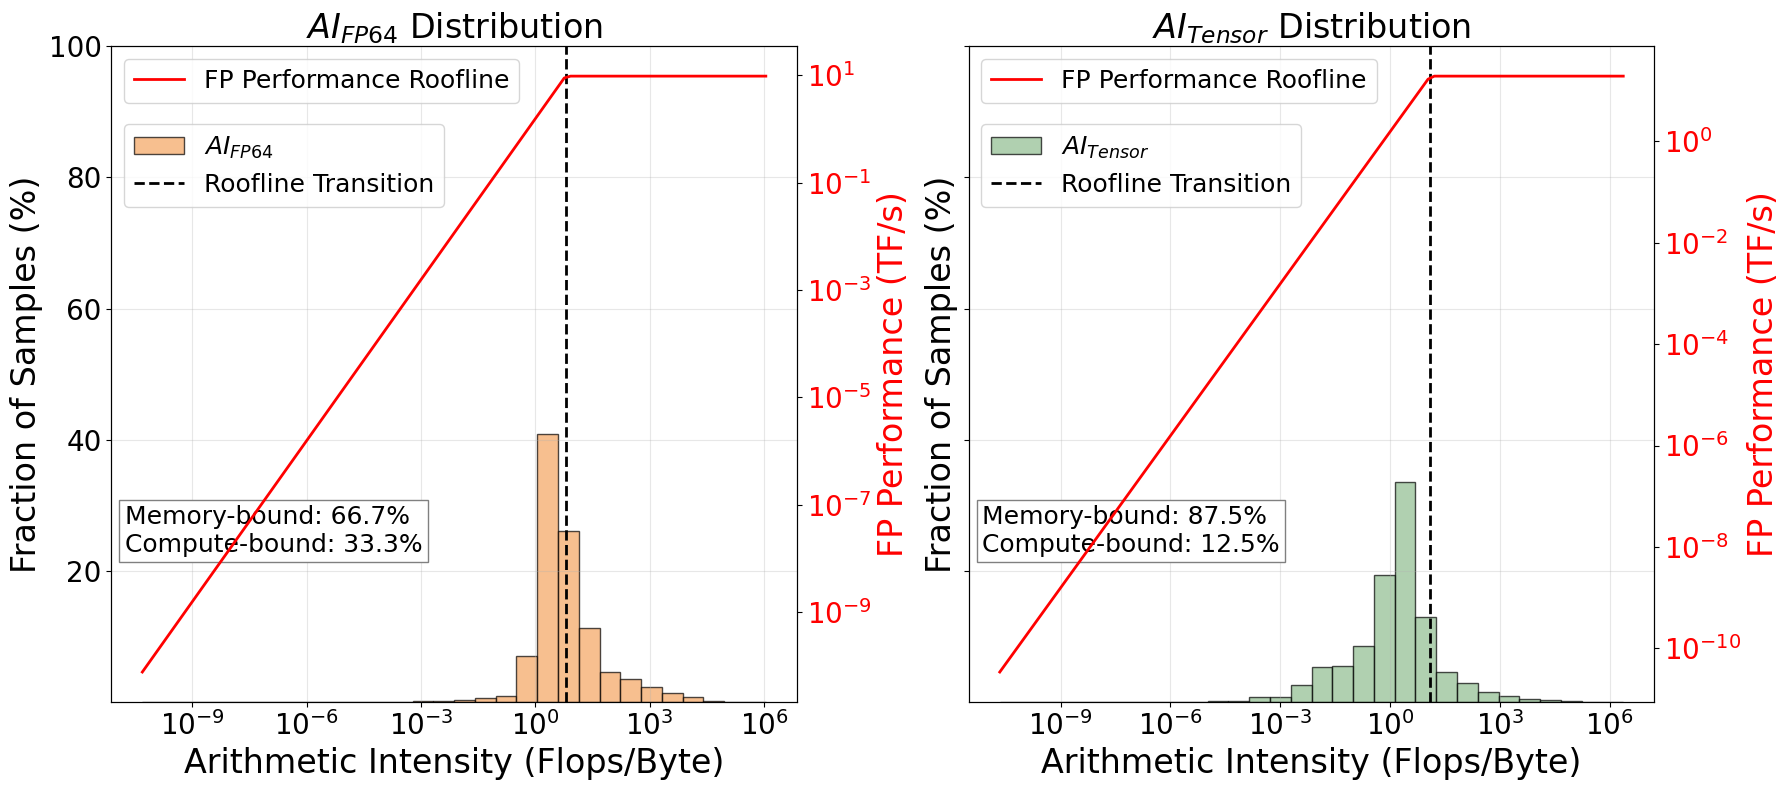

In [14]:
subplot_ai_dist(vasp_data, 'AI_fp64', 'AI_tensor', r'$AI_{FP64}$', r'$AI_{Tensor}$', 'Perlmutter VASP Jobs Arithmetic Intensity Distributions (March 2025)', color_1='sandybrown', color_2='darkseagreen')


Visualize Temporal Imbalance Factors

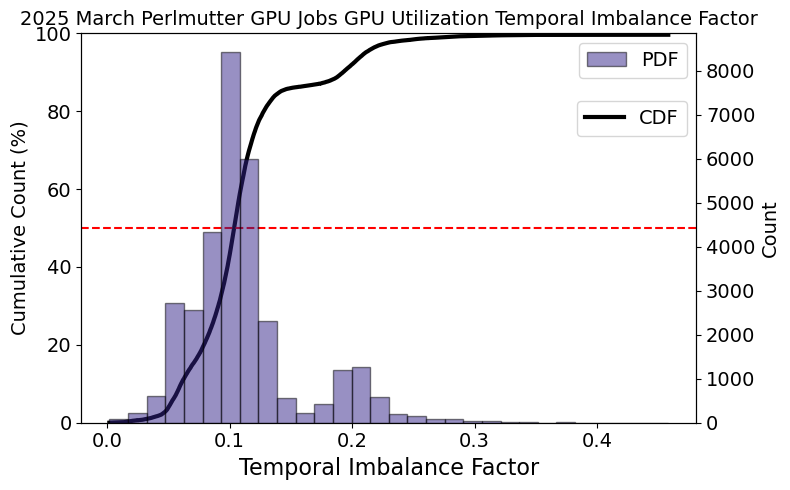

In [16]:
plot_tif_dist(vasp_data, 'gpu_tif_merged', '2025 March Perlmutter GPU Jobs GPU Utilization Temporal Imbalance Factor')


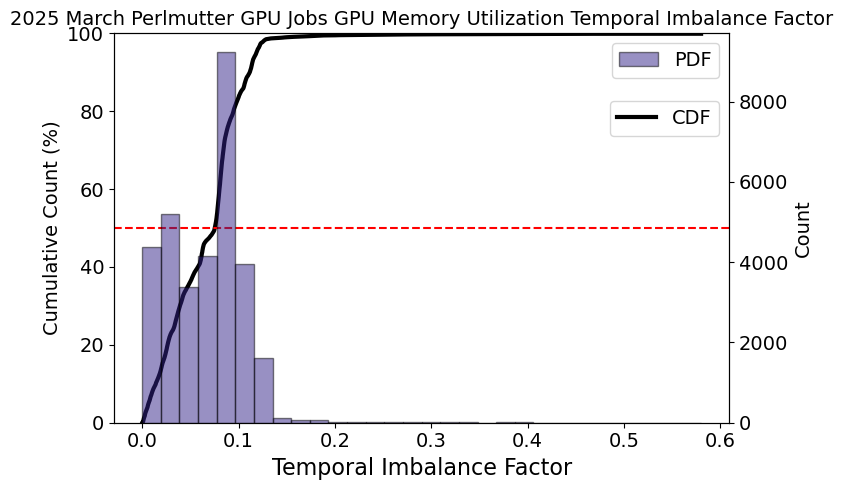

In [17]:
plot_tif_dist(vasp_data, 'mem_tif_merged', '2025 March Perlmutter GPU Jobs GPU Memory Utilization Temporal Imbalance Factor')


Visualize Spatial Imbalance Factors

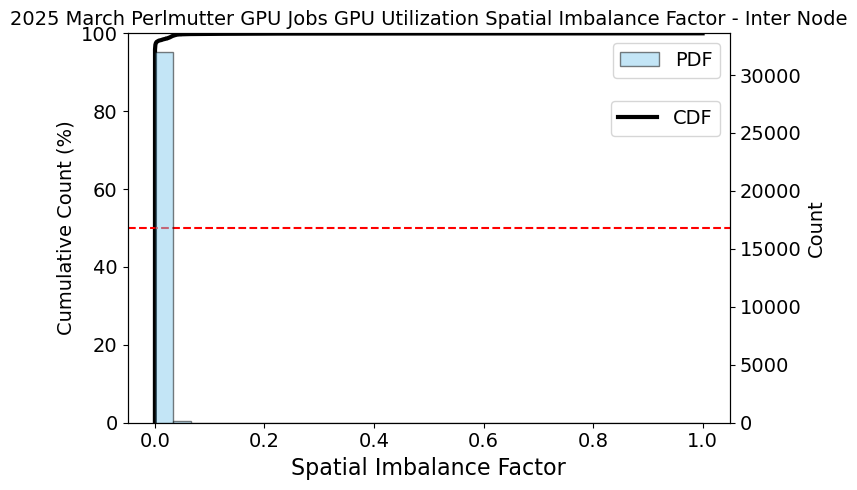

In [18]:
plot_sif_dist(vasp_data, 'gpu_sif_inter_normalized', '2025 March Perlmutter GPU Jobs GPU Utilization Spatial Imbalance Factor - Inter Node')


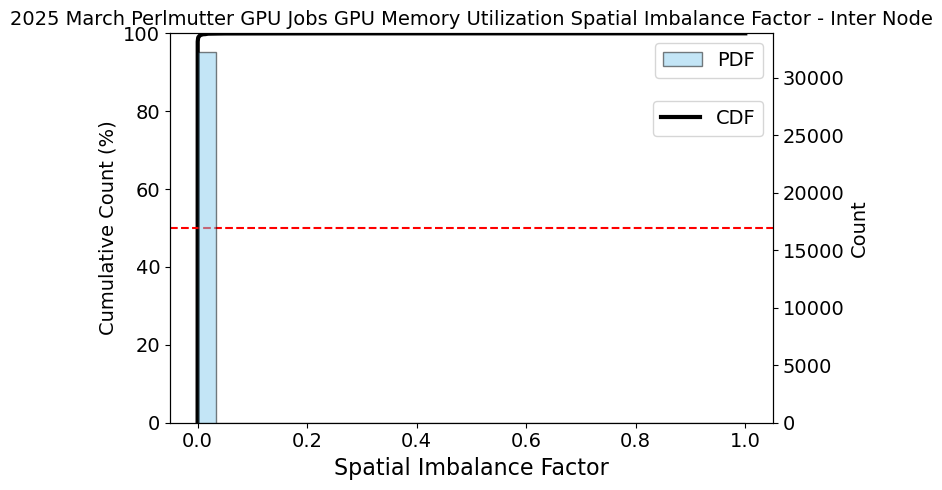

In [19]:
plot_sif_dist(vasp_data, 'mem_sif_inter_normalized', '2025 March Perlmutter GPU Jobs GPU Memory Utilization Spatial Imbalance Factor - Inter Node')


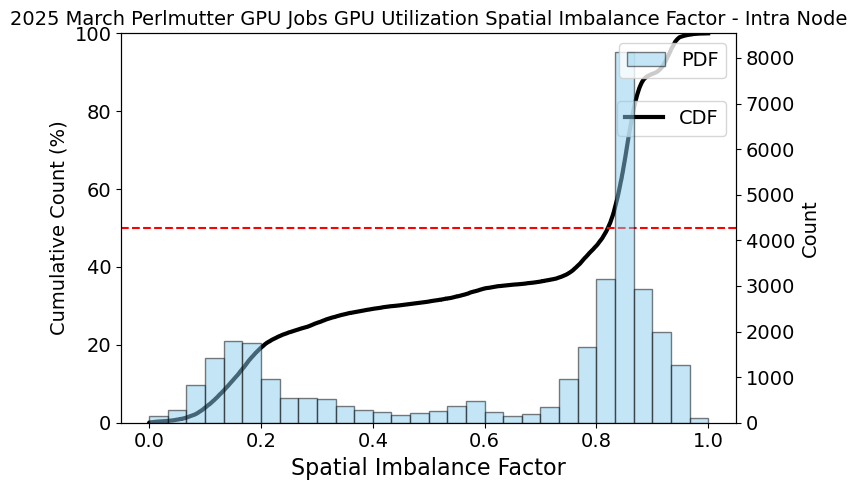

In [20]:
plot_sif_dist(vasp_data, 'gpu_sif_intra_normalized', '2025 March Perlmutter GPU Jobs GPU Utilization Spatial Imbalance Factor - Intra Node')



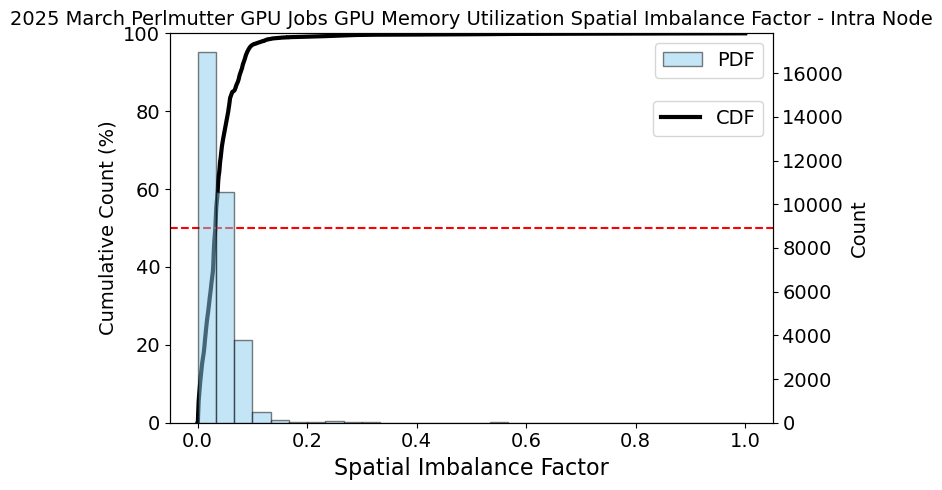

In [21]:
plot_sif_dist(vasp_data, 'mem_sif_intra_normalized', '2025 March Perlmutter GPU Jobs GPU Memory Utilization Spatial Imbalance Factor - Intra Node')


Temporal Variability of Average Power Consumption

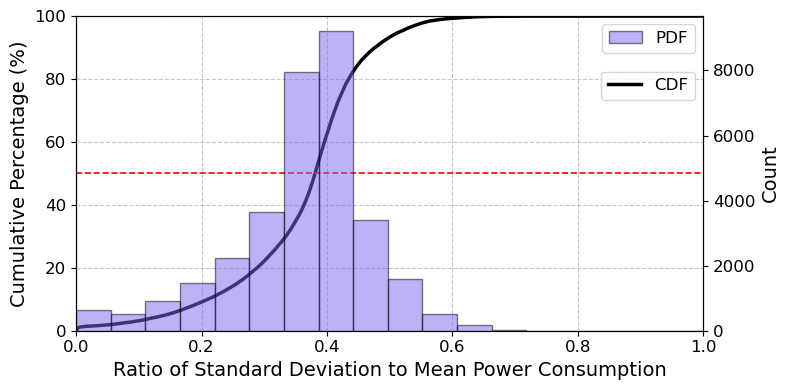

In [22]:
# Avg Power Temporal Imbalance
# Find std and mean of all avg_power readings for each job separately
# Take the ratio, store in an array
# Plot the distribution of these ratios

chunks = [pd.read_parquet(f"/pscratch/sd/b/boztop/ml_training_files/VASP_dcgm_data_part_{i+1}.parquet") for i in range(10)]
app_job_df = pd.concat(chunks, ignore_index=True)


app_job_df["MetricsCheck"] = app_job_df.apply(check_metrics, axis=1)
cleaned_df = app_job_df[app_job_df["MetricsCheck"].apply(lambda x: x.get("status") == "ok")].copy() # Disregard jobs with missing entries
cleaned_df = cleaned_df.apply(clean_and_compare, axis=1) # Disregard data points where timestamps are separated less than 10 seconds

ratio_list = find_tif_power(cleaned_df)
plot_ratio_dist(ratio_list)